In [1]:
import torch
import torch.nn as nn
import PIL.Image
import io
import numpy as np
import datasets
from torchvision.transforms.v2 import CenterCrop, PILToTensor, ToPILImage, Pad, CenterCrop
from types import SimpleNamespace
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent

In [3]:
device = "cuda"
valid_dataset = datasets.load_dataset("danjacobellis/kodak", split='validation')
checkpoint = torch.load('../hf/dance/LF_rgb_f16c12_v1.1.pth', map_location=device,weights_only=False)
config = checkpoint['config']
state_dict = checkpoint['state_dict']

model = AutoCodecND(
    dim=2,
    input_channels=config.input_channels,
    J=int(config.F**0.5),
    latent_dim=config.latent_dim,
    lightweight_encode=config.lightweight_encode,
    lightweight_decode=config.lightweight_decode,
    post_filter=config.post_filter
).to(device)
model.load_state_dict(state_dict)
model.eval();

7.382 KB
159.8005960444324x compression ratio
64.0x dimension reduction
22.731253218333336 dB PSNR


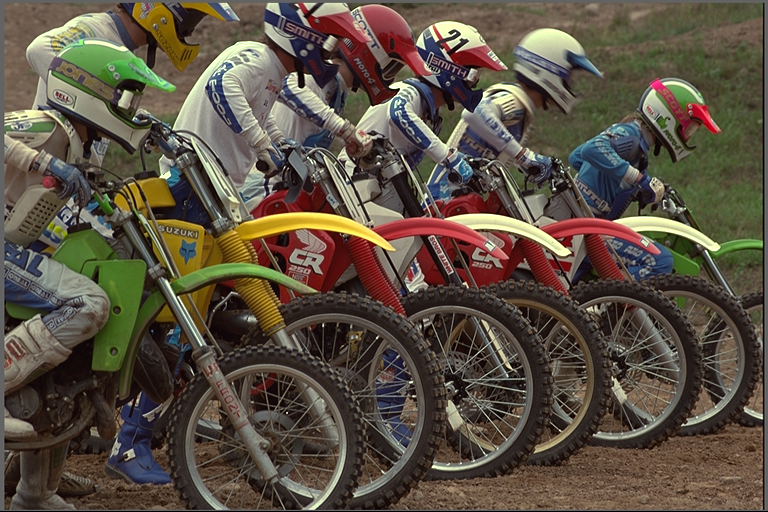

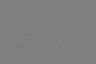

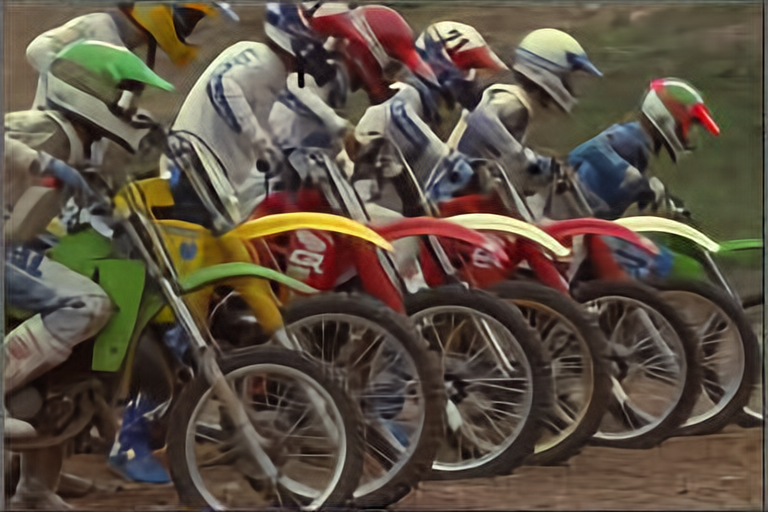

In [6]:
img = valid_dataset[4]['image']
x = PILToTensor()(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
x_orig = x[0]
orig_dim = x.numel()

x = Pad(0,padding_mode='reflect')(x)
with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round()

webp = latent_to_pil(latent.cpu(), n_bits=8, C=3)
buff = io.BytesIO()
webp[0].save(buff, format='WEBP', lossless=True)
size_bytes = len(buff.getbuffer())
print(f"{size_bytes/1e3} KB")
print(f"{orig_dim/size_bytes}x compression ratio")
print(f"{orig_dim/latent.numel()}x dimension reduction")

latent_decoded = pil_to_latent(webp, N=config.latent_dim, n_bits=8, C=3).to(device)

with torch.no_grad():
    x_hat = model.decode(latent_decoded)
    x_hat = CenterCrop((x_orig.shape[1],x_orig.shape[2]))(x_hat)

mse = torch.nn.functional.mse_loss(x_orig, x_hat[0])
PSNR = -10 * mse.log10().item() + 20*np.log10(2)
print(f"{PSNR} dB PSNR")

display(ToPILImage()(x_orig.clamp(-1, 1) / 2 + 0.5))  # Original image
display(webp[0])  # Compressed WEBP image
display(ToPILImage()(x_hat[0].clamp(-1, 1) / 2 + 0.5))  # Reconstructed image

9.904 KB
119.10823909531503x compression ratio
22.83696937561035 PSNR


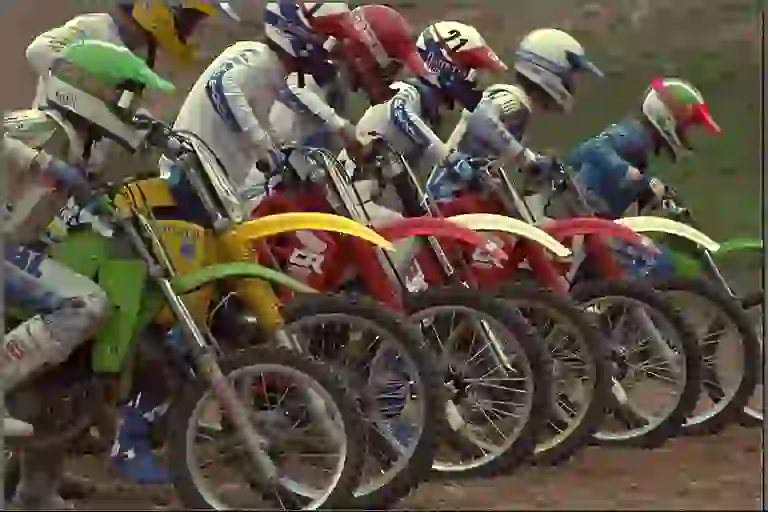

In [7]:
buff = io.BytesIO()
img.save(buff, format='WEBP', quality=0)
size_bytes = len(buff.getbuffer())
print(f"{size_bytes/1e3} KB")
print(f"{orig_dim/size_bytes}x compression ratio")
buff.seek(0)
webp = PIL.Image.open(buff)
MSE = torch.nn.functional.mse_loss(PILToTensor()(webp).to(torch.float)/255, x_orig.to("cpu")/2 + 0.5)
print(f"{-10*MSE.log10()} PSNR")
display(webp)

In [8]:
import io
import time
import torch
import numpy as np
from PIL import Image as PILImage
from torchvision.transforms import Pad, CenterCrop, PILToTensor
from datasets import Dataset
from piq import LPIPS, DISTS

# Initialize LPIPS and DISTS on GPU for faster computation
lpips_loss = LPIPS().to(device)
dists_loss = DISTS().to(device)

/home/dgj335/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dgj335/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
def compress_and_evaluate(sample, quality=0.1):
    img = sample['image']
    x_orig = PILToTensor()(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0  # Normalize to [-1, 1]
    orig_dim = x_orig.numel()  # Number of elements (width * height * channels)

    # Pad the image for neural codec
    pad_func = Pad(0, padding_mode='reflect')
    x_padded = pad_func(x_orig)

    # --- Neural Codec ---
    # Encode
    t0 = time.time()
    with torch.no_grad():
        z = model.encode(x_padded)
        latent = model.quantize.compand(z).round()
    neural_encode_time = time.time() - t0

    # Save latent as WebP lossless
    webp = latent_to_pil(latent.cpu(), n_bits=8, C=3)
    buff = io.BytesIO()
    webp[0].save(buff, format='WEBP', lossless=True)
    neural_size_bytes = len(buff.getbuffer())

    # Decode
    t0 = time.time()
    latent_decoded = pil_to_latent(webp, N=config.latent_dim, n_bits=8, C=3).to(device)
    with torch.no_grad():
        x_hat_padded = model.decode(latent_decoded)
    x_hat = CenterCrop((x_orig.shape[2], x_orig.shape[3]))(x_hat_padded).clamp(-1,1)
    neural_decode_time = time.time() - t0

    # Compute metrics for neural codec
    # Scale to [0, 255] for PSNR
    x_orig_255 = (x_orig / 2 + 0.5) * 255
    x_hat_255 = (x_hat / 2 + 0.5) * 255
    mse = torch.nn.functional.mse_loss(x_orig_255, x_hat_255)
    neural_PSNR = 10 * (255**2 / mse).log10().item()
    neural_bpp = 8 * neural_size_bytes / (img.width * img.height)

    # Scale to [0, 1] for LPIPS and DISTS
    x_orig_01 = x_orig / 2 + 0.5
    x_hat_01 = x_hat / 2 + 0.5
    neural_LPIPS_dB = -10 * np.log10(lpips_loss(x_orig_01.to("cuda"), x_hat_01.to("cuda")).item())
    neural_DISTS_dB = -10 * np.log10(dists_loss(x_orig_01.to("cuda"), x_hat_01.to("cuda")).item())

    # --- WebP Quality=0 ---
    # Encode
    t0 = time.time()
    buff = io.BytesIO()
    img.save(buff, format='WEBP', quality=quality)
    webp_size_bytes = len(buff.getbuffer())
    webp_encode_time = time.time() - t0

    # Decode
    t0 = time.time()
    buff.seek(0)
    webp_img = PILImage.open(buff)
    webp_decode_time = time.time() - t0

    # Compute metrics for WebP
    x_hat_webp = PILToTensor()(webp_img).to(torch.float).unsqueeze(0) / 255  # [0, 1]
    x_orig_255 = PILToTensor()(img).to(torch.float).unsqueeze(0)  # [0, 255]
    x_hat_webp_255 = x_hat_webp * 255
    mse_webp = torch.nn.functional.mse_loss(x_orig_255, x_hat_webp_255)
    webp_PSNR = 10 * (255**2 / mse_webp).log10().item()
    webp_bpp = 8 * webp_size_bytes / (img.width * img.height)

    # LPIPS and DISTS for WebP
    webp_LPIPS_dB = -10 * np.log10(lpips_loss(x_orig_255.to("cuda") / 255, x_hat_webp.to("cuda")).item())
    webp_DISTS_dB = -10 * np.log10(dists_loss(x_orig_255.to("cuda") / 255, x_hat_webp.to("cuda")).item())

    # Return dictionary of metrics
    return {
        'neural_size_bytes': neural_size_bytes,
        'neural_bpp': neural_bpp,
        'neural_PSNR': neural_PSNR,
        'neural_LPIPS_dB': neural_LPIPS_dB,
        'neural_DISTS_dB': neural_DISTS_dB,
        'neural_encode_time': neural_encode_time,
        'neural_decode_time': neural_decode_time,
        'webp_size_bytes': webp_size_bytes,
        'webp_bpp': webp_bpp,
        'webp_PSNR': webp_PSNR,
        'webp_LPIPS_dB': webp_LPIPS_dB,
        'webp_DISTS_dB': webp_DISTS_dB,
        'webp_encode_time': webp_encode_time,
        'webp_decode_time': webp_decode_time,
    }

# Apply the function to the dataset
results_dataset = valid_dataset.map(compress_and_evaluate)

metrics = [
     'neural_bpp',
     'neural_PSNR',
     'neural_LPIPS_dB',
     'neural_DISTS_dB', 
     'neural_encode_time',
     'neural_decode_time',
     'webp_bpp',
     'webp_PSNR',
     'webp_LPIPS_dB',
     'webp_DISTS_dB', 
     'webp_encode_time',
     'webp_decode_time',
]

for metric in metrics:
    μ = np.mean(results_dataset[metric])
    print(f"{metric}: {μ}")

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

neural_bpp: 0.1177554660373264
neural_PSNR: 26.811086138089497
neural_LPIPS_dB: 3.8424697845005995
neural_DISTS_dB: 8.003440761115158
neural_encode_time: 0.004104544719060262
neural_decode_time: 0.0049123068650563555
webp_bpp: 0.12959459092881945
webp_PSNR: 26.419024368127186
webp_LPIPS_dB: 3.085883896712106
webp_DISTS_dB: 6.973474207290071
webp_encode_time: 0.013991177082061768
webp_decode_time: 0.0001619259516398112
